In [1]:
import pandas as pd
import numpy as np
from data_prep import DataPrep
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


In [ ]:
# Pipeline 
# 1. Use Classifiers to classify the returns (int)
# 2. Predict using data
# 3. Construct Porfolio Returns 

In [2]:
data_obj = DataPrep()
data_obj.data_initialization()
data_obj.data_construction()
id_df, feature_df, return_df = data_obj.data_slicing()

data initialized
DataFrame size: (4135225, 135)
data construction complete
DataFrame size: (987322, 137)


In [4]:
data_obj.stock_data.dropna(axis=0)

,id,date,size_grp,prc,ret_exc_lead1m,market_equity,div12m_me,chcsho_12m,eqnpo_12m,ret_1_0,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj_prof,qmj_safety,ticker,sector
4635,10026,19890228,micro,-0.158626,0.174911,-0.179675,-0.425807,-0.014759,-0.163771,-0.354179,...,0.481660,0.120549,-0.006997,0.332431,0.166266,-1.083387,1.490781,-0.852828,JJSF,Consumer Staples
4637,10026,19890428,micro,-0.113281,0.364309,-0.179241,-0.425807,-0.007715,-0.257828,0.659364,...,-0.128688,0.025499,-0.013491,0.355171,0.315901,-1.074234,0.688426,-0.713522,JJSF,Consumer Staples
4638,10026,19890531,micro,-0.089097,0.279204,-0.179037,-0.425807,-0.007715,-0.257828,0.399481,...,-0.638902,-0.099887,-0.025263,0.381019,0.572294,-1.069658,0.670506,-0.689762,JJSF,Consumer Staples
4639,10026,19890630,small,-0.067936,0.731337,-0.177971,-0.425807,0.076787,-1.262325,0.308847,...,-1.007670,-0.241536,-0.053992,0.469282,1.360597,-1.065082,0.653260,-0.720597,JJSF,Consumer Staples
4640,10026,19890731,small,-0.019568,-0.528325,-0.177444,-0.425807,0.076787,-1.262325,0.761002,...,-0.998700,-0.296370,-0.050818,0.535554,-0.117888,-1.060506,0.697369,-0.636869,JJSF,Consumer Staples
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928473,93436,20220729,mega,10.351702,-0.534845,29.317642,-0.425807,-0.016616,-0.138669,1.950629,...,1.200048,-0.297863,0.697137,0.956769,0.554143,-0.346642,1.369369,0.390198,TSLA,Consumer Discretionary
3928474,93436,20220831,mega,2.904992,-0.316050,27.179259,-0.425807,-0.020771,-0.082012,-0.539417,...,1.007974,-0.051694,0.712651,0.906759,-0.783997,-0.342066,1.370937,0.390262,TSLA,Consumer Discretionary
3928475,93436,20220930,mega,2.779720,-0.974707,26.356915,-0.425807,-0.018816,-0.108761,-0.320110,...,0.911516,-0.333763,0.731090,0.868214,-0.917142,-0.337490,1.374836,0.400469,TSLA,Consumer Discretionary
3928476,93436,20221031,mega,2.323732,-0.991569,22.582165,-0.425807,-0.018936,-0.107117,-0.977278,...,0.923316,0.202283,0.702894,0.747563,-0.400236,-0.332914,1.354931,0.410256,TSLA,Consumer Discretionary


In [35]:
imputer = SimpleImputer(strategy='mean')
feature_data_imputed = imputer.fit_transform(feature_df)
feature_data_imputed = pd.DataFrame(data=feature_data_imputed, columns=feature_df.columns)
pca = PCA()   
feature_data_imputedx = pca.fit(feature_data_imputed)   
# reducedData = pca.transform(data_imputed)   

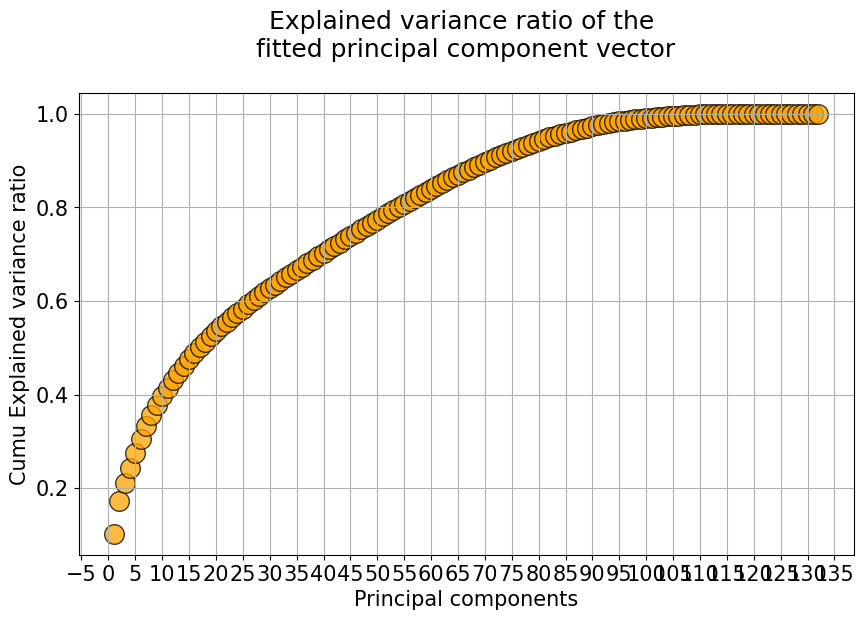

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(feature_data_imputedx.explained_variance_ratio_))],
            y=pd.Series(feature_data_imputedx.explained_variance_ratio_).cumsum(),
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(feature_data_imputedx.explained_variance_ratio_))],fontsize=15)

# Setting x-ticks interval
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))  # Set interval of 1 to ensure each principal component is marked

plt.yticks(fontsize=15)
plt.ylabel("Cumu Explained variance ratio",fontsize=15)
plt.show()

In [37]:
dfx_trans = pca.transform(feature_data_imputed)


In [43]:
dfx_trans[1]

0         0.171551
1        -0.278781
2         0.170374
3         0.235742
4        -1.181479
            ...   
987317   -8.145300
987318   -7.836223
987319   -6.361065
987320   -5.058857
987321   -4.391333
Name: 1, Length: 987322, dtype: float64

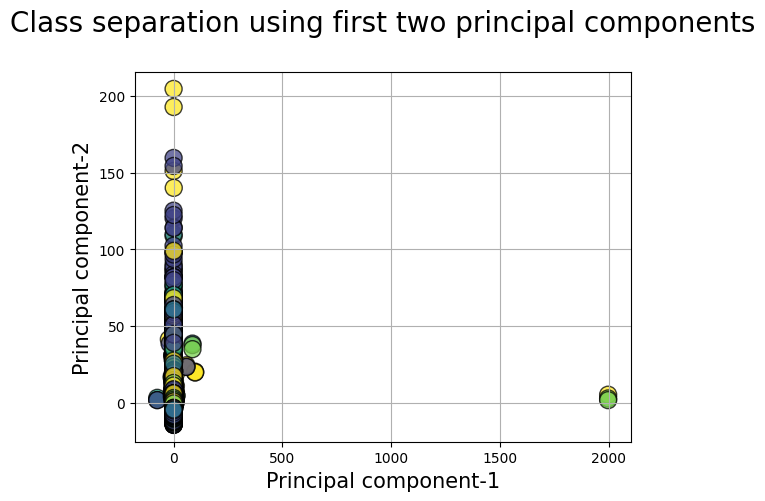

In [74]:
dfx_trans = pd.DataFrame(dfx_trans)
values = [-9999999]+[return_df['ret_exc_lead1m'].quantile(i) for i in np.arange(0,1,0.2)]+[9999999999]
rets = pd.cut(return_df['ret_exc_lead1m'], values, labels=[1,2,3,4,5,6]).fillna(3).astype(int)
plt.scatter(dfx_trans[0],dfx_trans[1],c=rets,edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [79]:
dfx_trans[0].describe()

count    9.873220e+05
mean    -1.511300e-19
std      3.493178e+00
min     -7.540807e+01
25%     -2.596987e-02
50%      2.922211e-03
75%      2.001382e-02
max      1.996383e+03
Name: 0, dtype: float64